# Importações essenciais

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample

# Configurações gerais
RANDOM_STATE = 42  
sns.set(style="whitegrid")


# Funções Auxiliares

In [2]:
def load_and_clean_data(filepath):
    """
    Carrega o arquivo CSV, converte a coluna 'class' para valores binários e remove duplicatas.
    """
    data = pd.read_csv(filepath)
    data['class'] = data['class'].replace({'g': 1, 'h': 0})
    num_rows_before = data.shape[0]
    data.drop_duplicates(inplace=True)
    num_rows_after = data.shape[0]
    num_duplicates_removed = num_rows_before - num_rows_after
    print(f"Número de linhas duplicadas removidas: {num_duplicates_removed}")
    return data

def plot_histograms_boxplots(data, title_prefix):
    """
    Plota histogramas e boxplots para cada feature numérica, diferenciando as classes.
    Todos os histogramas e boxplots de uma base são plotados em uma única imagem com múltiplos subplots.
    """
    numeric_cols = data.select_dtypes(include=[np.number]).columns.drop('class')
    num_cols = len(numeric_cols)
    num_rows = (num_cols + 3) // 4  

    plt.figure(figsize=(20, num_rows * 4))
    for idx, col in enumerate(numeric_cols):
        plt.subplot(num_rows, 4, idx + 1)
        for class_value, color in zip([0, 1], ['red', 'blue']):
            sns.histplot(
                data[data['class'] == class_value][col],
                color=color,
                label=f'Classe {class_value}',
                kde=True,
                stat='density',
                alpha=0.5
            )
        plt.title(f"{col}")
        plt.xlabel('')
        plt.ylabel('Densidade')
        if idx == 0:
            plt.legend()
    plt.suptitle(f"{title_prefix} - Histogramas")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    plt.figure(figsize=(20, num_rows * 4))
    for idx, col in enumerate(numeric_cols):
        plt.subplot(num_rows, 4, idx + 1)
        sns.boxplot(x='class', y=col, data=data, palette=['red', 'blue'])
        plt.title(f"{col}")
        plt.xlabel('Classe')
        plt.ylabel('')
    plt.suptitle(f"{title_prefix} - Boxplots")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def generate_latex_table(data, title):
    """
    Gera uma tabela LaTeX com estatísticas descritivas.
    """
    desc = data.describe().transpose()
    latex_table = desc.to_latex(float_format="%.3f")
    print(f"Tabela LaTeX para {title}:\n")
    print(latex_table)
    print("\n" + "-" * 80 + "\n")

def undersample_data_safe(X, y):
    """
    Realiza o undersampling para balancear as classes no conjunto de treinamento.
    """
    data = pd.concat([X, y], axis=1)
    class_counts = data['class'].value_counts()

    majority_class_value = class_counts.idxmax()
    minority_class_value = class_counts.idxmin()

    majority_class = data[data['class'] == majority_class_value]
    minority_class = data[data['class'] == minority_class_value]

    if len(minority_class) > 0 and len(majority_class) > 0:
        majority_downsampled = resample(
            majority_class,
            replace=False,
            n_samples=len(minority_class),
            random_state=RANDOM_STATE
        )
        balanced_data = pd.concat([majority_downsampled, minority_class])

        return balanced_data.drop(columns=['class']).reset_index(drop=True), balanced_data['class'].reset_index(drop=True)
    else:
        print("Uma das classes está ausente. Retornando os dados originais.")
        return X.reset_index(drop=True), y.reset_index(drop=True)

def perform_cross_validation(X, y, models, cv_folds):
    """
    Realiza validação cruzada usando k-folds e retorna as acurácias médias.
    """
    results = {}
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    for model_name, model in models.items():
        cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
        results[model_name] = cv_scores.mean()
    return results

def apply_pca(data, n_components=0.95):
    """
    Aplica PCA ao conjunto de dados e retorna o DataFrame transformado.
    """
    features = data.drop(columns=['class'])
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    pca_features = pca.fit_transform(features)
    pca_feature_names = [f'PC{i+1}' for i in range(pca_features.shape[1])]
    data_pca = pd.DataFrame(pca_features, columns=pca_feature_names)
    data_pca['class'] = data['class'].reset_index(drop=True)
    return data_pca


# Importação da base em csv

In [3]:

file_path = "C:/Users/55819/Downloads/magic.csv" 
data = load_and_clean_data(file_path)


Número de linhas duplicadas removidas: 115


# Análise da base original

In [4]:

bases_completas = {}
numeric_cols = data.select_dtypes(include=[np.number]).columns.drop('class')

# Base original
bases_completas['Original'] = data.copy()

# Winsorização a 1%
winsor_limits_1 = (0.01, 0.01)
data_winsor_1 = data.copy()
for col in numeric_cols:
    data_winsor_1[col] = winsorize(data_winsor_1[col], limits=winsor_limits_1)
bases_completas['Winsorizado 1%'] = data_winsor_1

# Winsorização a 5%
winsor_limits_5 = (0.05, 0.05)
data_winsor_5 = data.copy()
for col in numeric_cols:
    data_winsor_5[col] = winsorize(data_winsor_5[col], limits=winsor_limits_5)
bases_completas['Winsorizado 5%'] = data_winsor_5

# Normalização da base original
data_normalizado = data.copy()
scaler_original = MinMaxScaler()
data_normalizado[numeric_cols] = scaler_original.fit_transform(data_normalizado[numeric_cols])
bases_completas['Normalizado'] = data_normalizado

# Normalização da base winsorizada a 1%
data_winsor_1_norm = data_winsor_1.copy()
scaler_winsor_1 = MinMaxScaler()
data_winsor_1_norm[numeric_cols] = scaler_winsor_1.fit_transform(data_winsor_1_norm[numeric_cols])
bases_completas['Normalizado + Winsorizado 1%'] = data_winsor_1_norm

# Normalização da base winsorizada a 5%
data_winsor_5_norm = data_winsor_5.copy()
scaler_winsor_5 = MinMaxScaler()
data_winsor_5_norm[numeric_cols] = scaler_winsor_5.fit_transform(data_winsor_5_norm[numeric_cols])
bases_completas['Normalizado + Winsorizado 5%'] = data_winsor_5_norm

# PCA na base original
bases_completas['PCA'] = apply_pca(data)

# PCA na base normalizada
bases_completas['PCA Normalizado'] = apply_pca(data_normalizado)

# PCA na base winsorizada a 1%
bases_completas['PCA Winsorizado 1%'] = apply_pca(data_winsor_1)

# PCA na base winsorizada a 5%
bases_completas['PCA Winsorizado 5%'] = apply_pca(data_winsor_5)

# PCA na base normalizada e winsorizada a 1%
bases_completas['PCA Normalizado + Winsorizado 1%'] = apply_pca(data_winsor_1_norm)

# PCA na base normalizada e winsorizada a 5%
bases_completas['PCA Normalizado + Winsorizado 5%'] = apply_pca(data_winsor_5_norm)


In [ ]:
for name, dataset in bases_completas.items():
    print(f"\nAnalisando a base completa: {name}")
    plot_histograms_boxplots(dataset, f"{name} (Completo)")
    generate_latex_table(dataset, f"{name} (Completo)")


 # Divisão dos conjuntos de treino, validação e teste

In [5]:

train_data, temp_data = train_test_split(data, test_size=0.30, random_state=RANDOM_STATE)

validation_data, test_data = train_test_split(
    temp_data, test_size=0.5, random_state=RANDOM_STATE
)

print(f"Tamanho do conjunto de treino: {len(train_data)}")
print(f"Tamanho do conjunto de validação: {len(validation_data)}")
print(f"Tamanho do conjunto de teste: {len(test_data)}")


Tamanho do conjunto de treino: 13233
Tamanho do conjunto de validação: 2836
Tamanho do conjunto de teste: 2836


# Análise da base de treino

In [6]:
bases_treino = {}

# Base original de treino
bases_treino['Original'] = train_data.copy()

# Winsorização a 1% no conjunto de treino
train_winsor_1 = train_data.copy()
for col in numeric_cols:
    train_winsor_1[col] = winsorize(train_winsor_1[col], limits=winsor_limits_1)
bases_treino['Winsorizado 1%'] = train_winsor_1

# Winsorização a 5% no conjunto de treino
train_winsor_5 = train_data.copy()
for col in numeric_cols:
    train_winsor_5[col] = winsorize(train_winsor_5[col], limits=winsor_limits_5)
bases_treino['Winsorizado 5%'] = train_winsor_5

# Normalização da base original de treino
train_normalizado = train_data.copy()
scaler_train_original = MinMaxScaler()
train_normalizado[numeric_cols] = scaler_train_original.fit_transform(train_normalizado[numeric_cols])
bases_treino['Normalizado'] = train_normalizado

# Normalização da base winsorizada a 1% de treino
train_winsor_1_norm = train_winsor_1.copy()
scaler_train_winsor_1 = MinMaxScaler()
train_winsor_1_norm[numeric_cols] = scaler_train_winsor_1.fit_transform(train_winsor_1_norm[numeric_cols])
bases_treino['Normalizado + Winsorizado 1%'] = train_winsor_1_norm

# Normalização da base winsorizada a 5% de treino
train_winsor_5_norm = train_winsor_5.copy()
scaler_train_winsor_5 = MinMaxScaler()
train_winsor_5_norm[numeric_cols] = scaler_train_winsor_5.fit_transform(train_winsor_5_norm[numeric_cols])
bases_treino['Normalizado + Winsorizado 5%'] = train_winsor_5_norm

# PCA na base original de treino
bases_treino['PCA'] = apply_pca(train_data)

# PCA na base normalizada de treino
bases_treino['PCA Normalizado'] = apply_pca(train_normalizado)

# PCA na base winsorizada a 1% de treino
bases_treino['PCA Winsorizado 1%'] = apply_pca(train_winsor_1)

# PCA na base winsorizada a 5% de treino
bases_treino['PCA Winsorizado 5%'] = apply_pca(train_winsor_5)

# PCA na base normalizada e winsorizada a 1% de treino
bases_treino['PCA Normalizado + Winsorizado 1%'] = apply_pca(train_winsor_1_norm)

# PCA na base normalizada e winsorizada a 5% de treino
bases_treino['PCA Normalizado + Winsorizado 5%'] = apply_pca(train_winsor_5_norm)


In [ ]:
for name, dataset in bases_treino.items():
    print(f"\nAnalisando a base de treino: {name}")
    plot_histograms_boxplots(dataset, f"{name} (Treino)")
    generate_latex_table(dataset, f"{name} (Treino)")


# Análise da base de treino com undersampling

In [7]:
bases_treino_undersampled = {}

for name, dataset in bases_treino.items():
    print(f"\nAplicando undersampling na base de treino: {name}")
    X_train = dataset.drop(columns=['class'])
    y_train = dataset['class']
    X_train_balanced, y_train_balanced = undersample_data_safe(X_train, y_train)
    balanced_dataset = pd.concat([X_train_balanced, y_train_balanced], axis=1)
    bases_treino_undersampled[name] = balanced_dataset



Aplicando undersampling na base de treino: Original

Aplicando undersampling na base de treino: Winsorizado 1%

Aplicando undersampling na base de treino: Winsorizado 5%

Aplicando undersampling na base de treino: Normalizado

Aplicando undersampling na base de treino: Normalizado + Winsorizado 1%

Aplicando undersampling na base de treino: Normalizado + Winsorizado 5%

Aplicando undersampling na base de treino: PCA

Aplicando undersampling na base de treino: PCA Normalizado

Aplicando undersampling na base de treino: PCA Winsorizado 1%

Aplicando undersampling na base de treino: PCA Winsorizado 5%

Aplicando undersampling na base de treino: PCA Normalizado + Winsorizado 1%

Aplicando undersampling na base de treino: PCA Normalizado + Winsorizado 5%


In [ ]:
for name, dataset in bases_treino_undersampled.items():
    print(f"\nAnalisando a base de treino com undersampling: {name}")
    plot_histograms_boxplots(dataset, f"{name} (Treino Undersampled)")
    generate_latex_table(dataset, f"{name} (Treino Undersampled)")


# Análise do conjunto de validação


Analisando o conjunto de validação após Winsorização a 1% e Normalização (usando escala do treino antes do undersampling):


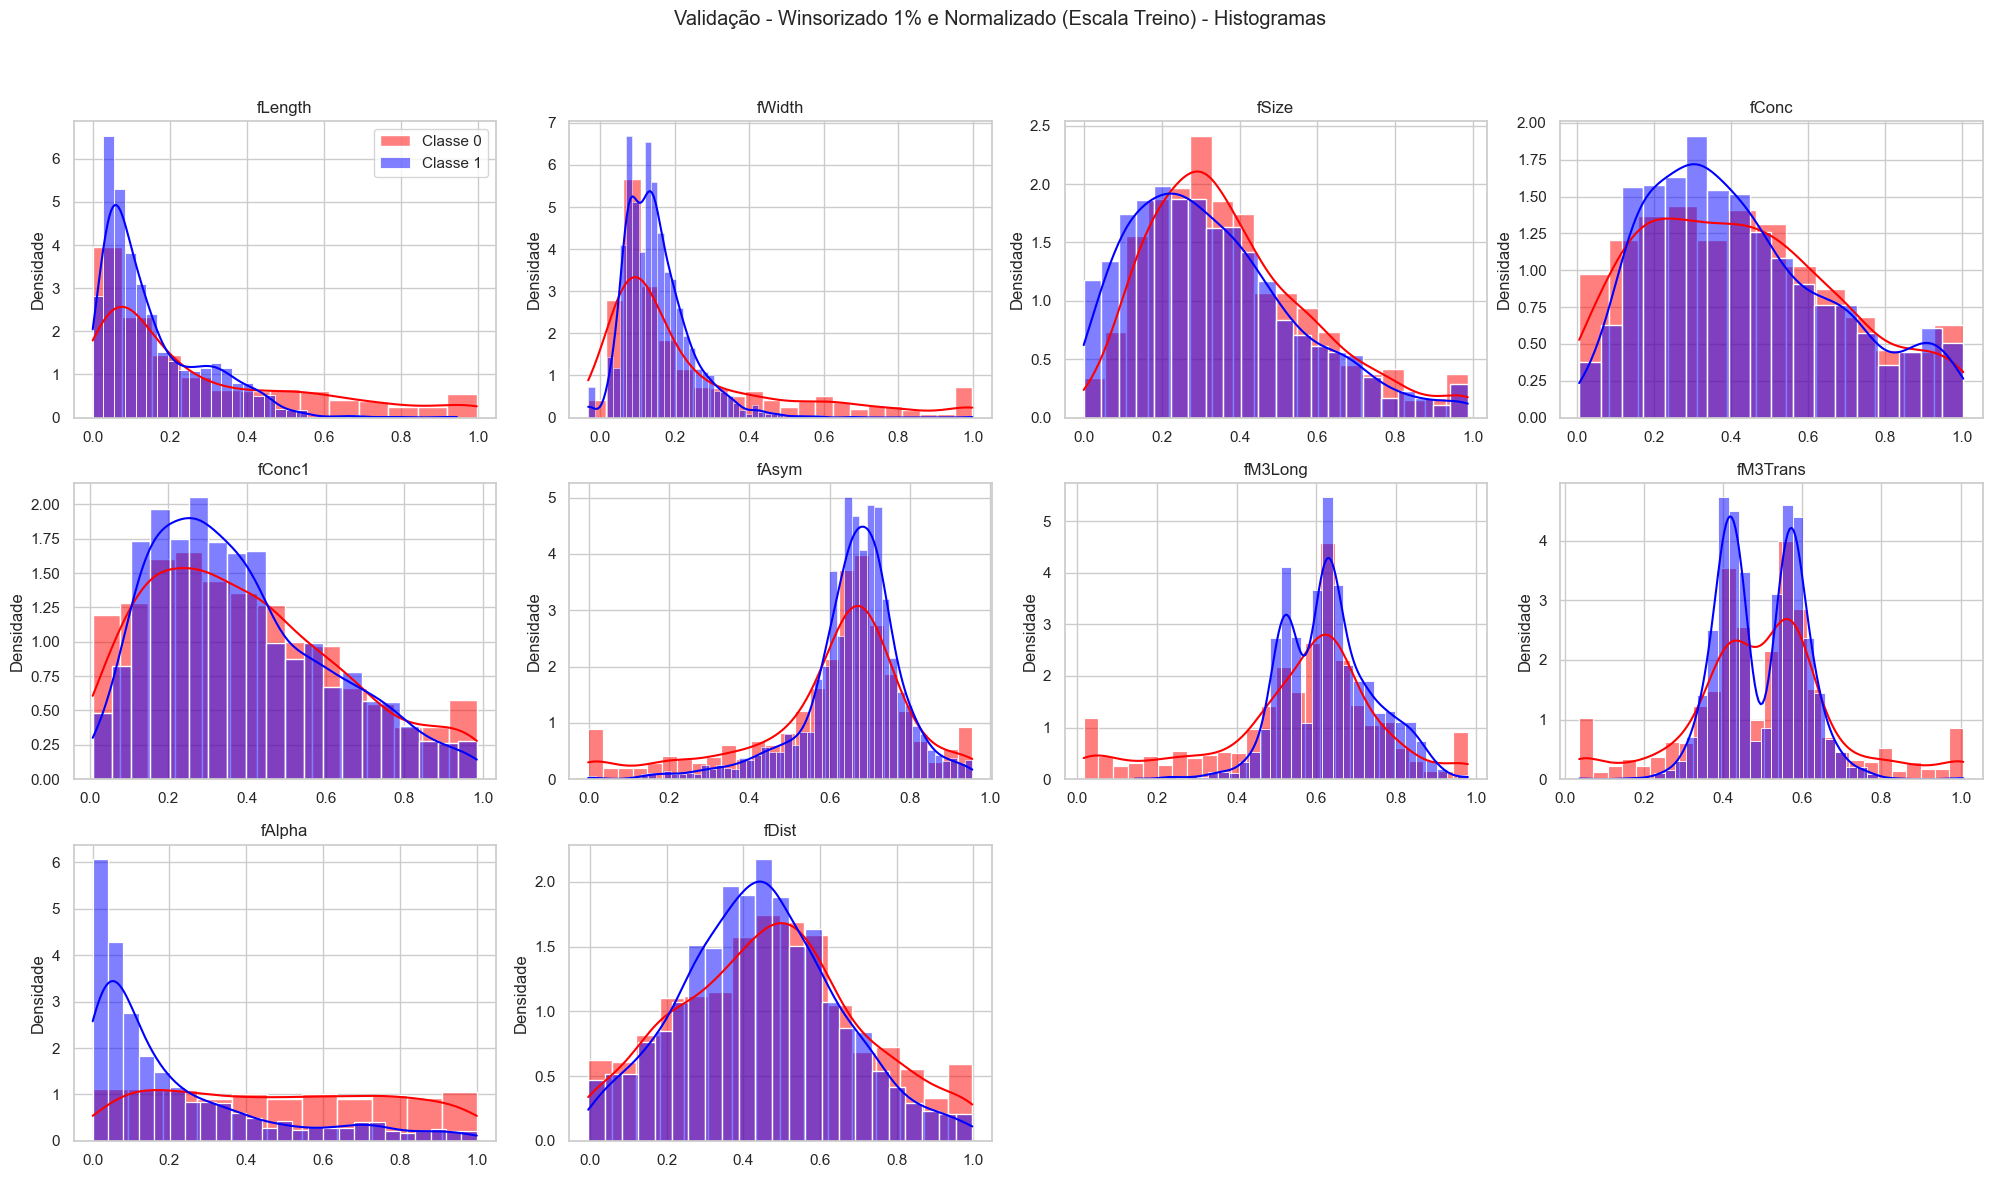

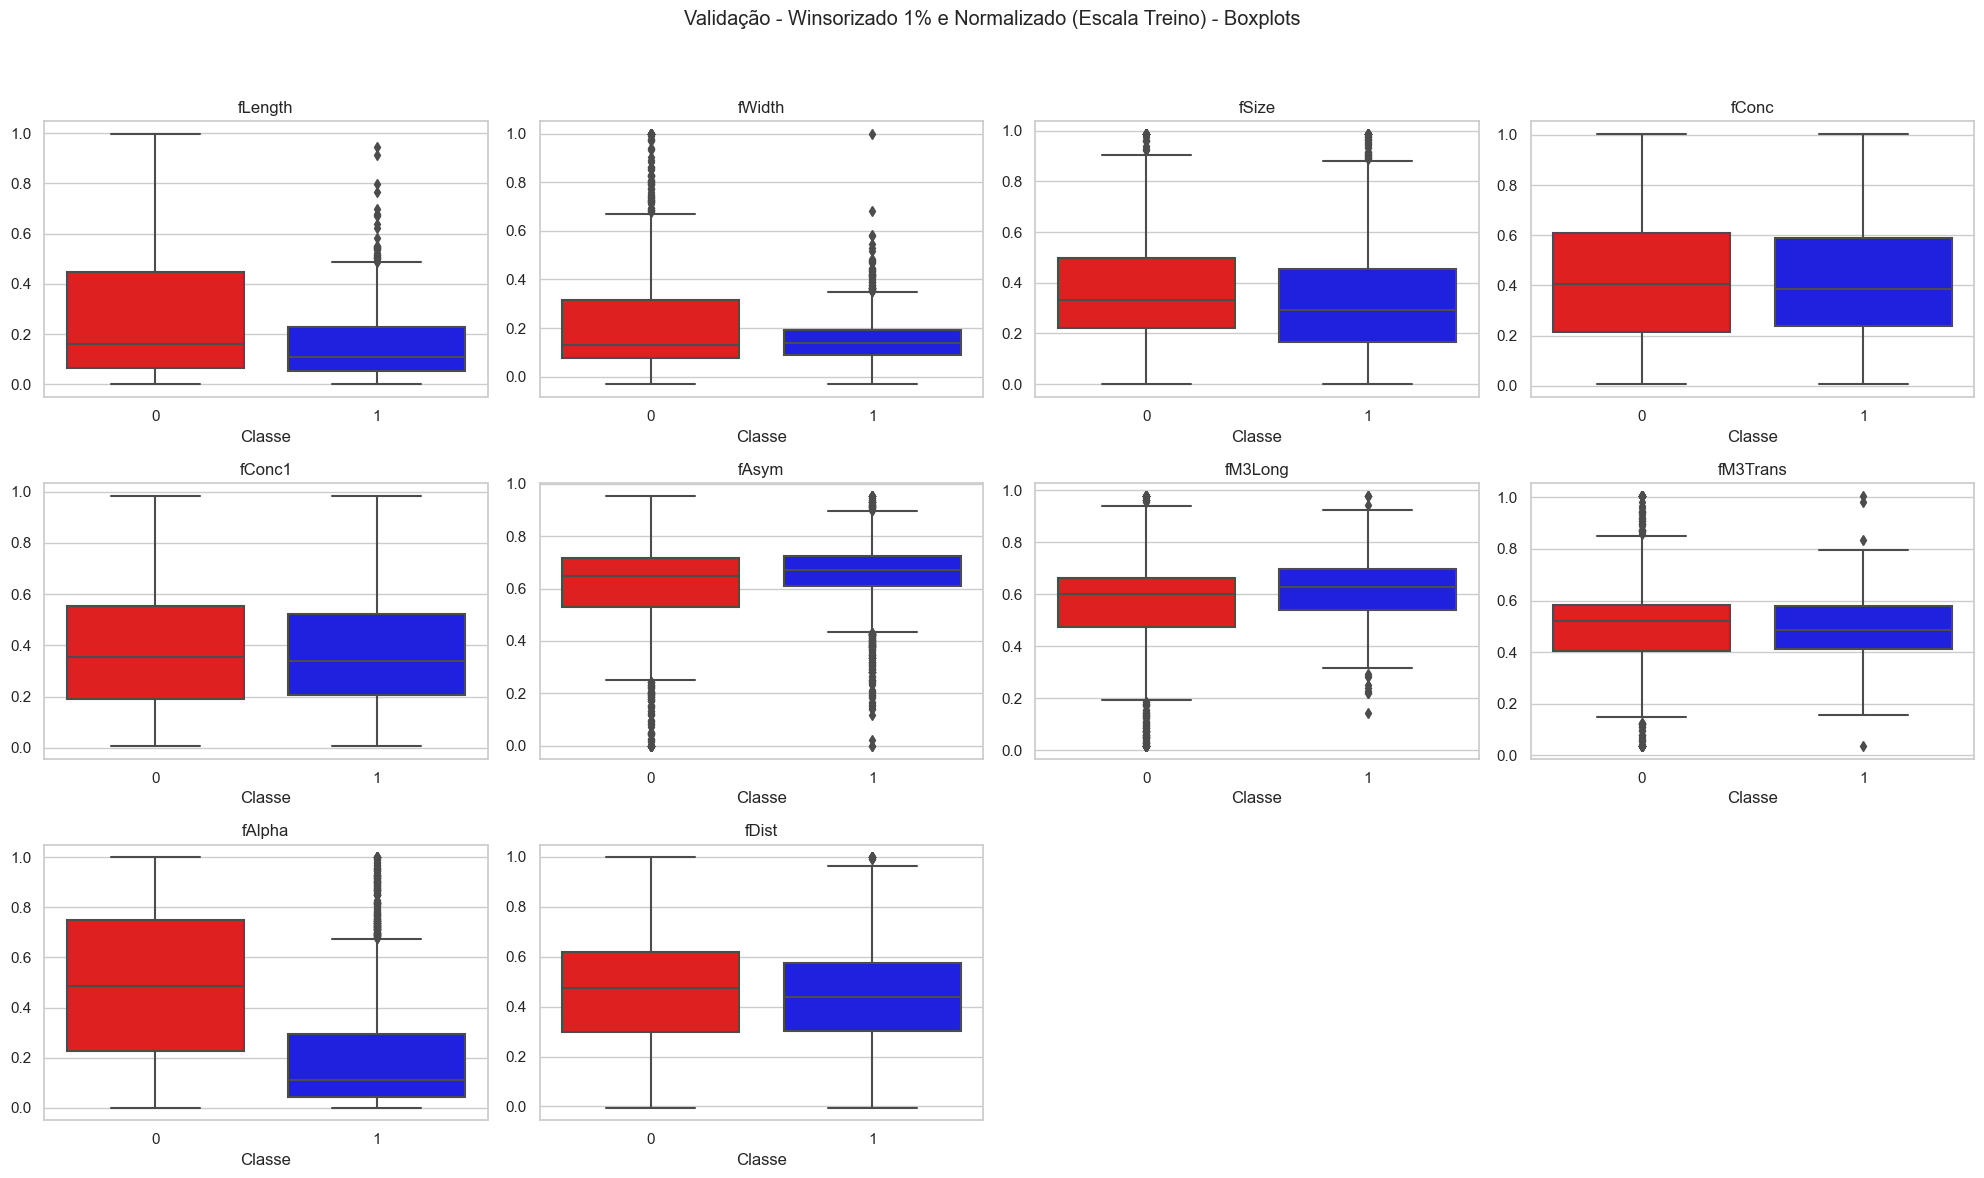

Tabela LaTeX para Validação - Winsorizado 1% e Normalizado (Escala Treino):

\begin{tabular}{lrrrrrrrr}
\toprule
{} &    count &  mean &   std &    min &   25\% &   50\% &   75\% &   max \\
\midrule
fLength  & 2836.000 & 0.196 & 0.202 &  0.000 & 0.056 & 0.118 & 0.277 & 0.997 \\
fWidth   & 2836.000 & 0.182 & 0.167 & -0.032 & 0.083 & 0.135 & 0.209 & 0.999 \\
fSize    & 2836.000 & 0.346 & 0.215 & -0.002 & 0.185 & 0.311 & 0.471 & 0.987 \\
fConc    & 2836.000 & 0.428 & 0.248 &  0.005 & 0.233 & 0.393 & 0.594 & 1.004 \\
fConc1   & 2836.000 & 0.386 & 0.232 &  0.007 & 0.201 & 0.345 & 0.538 & 0.985 \\
fAsym    & 2836.000 & 0.636 & 0.161 & -0.001 & 0.592 & 0.664 & 0.724 & 0.955 \\
fM3Long  & 2836.000 & 0.603 & 0.161 &  0.016 & 0.526 & 0.621 & 0.688 & 0.980 \\
fM3Trans & 2836.000 & 0.497 & 0.141 &  0.035 & 0.409 & 0.495 & 0.581 & 1.007 \\
fAlpha   & 2836.000 & 0.307 & 0.292 &  0.000 & 0.061 & 0.193 & 0.506 & 1.000 \\
fDist    & 2836.000 & 0.452 & 0.218 & -0.005 & 0.300 & 0.450 & 0.589 & 0.998 \\
c

C:\Users\55819\AppData\Local\Temp\ipykernel_33340\3556760450.py:60: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = desc.to_latex(float_format="%.3f")


In [8]:
validation_winsor_1 = validation_data.copy()
for col in numeric_cols:
    validation_winsor_1[col] = winsorize(validation_winsor_1[col], limits=winsor_limits_1)
validation_winsor_1_norm = validation_winsor_1
validation_winsor_1_norm[numeric_cols] = scaler_train_winsor_1.transform(validation_winsor_1_norm[numeric_cols])


print("\nAnalisando o conjunto de validação após Winsorização a 1% e Normalização (usando escala do treino antes do undersampling):")
plot_histograms_boxplots(validation_winsor_1_norm, "Validação - Winsorizado 1% e Normalizado (Escala Treino)")
generate_latex_table(validation_winsor_1_norm, "Validação - Winsorizado 1% e Normalizado (Escala Treino)")



# Validação Cruzada


Realizando validação cruzada para a base: Original

Realizando validação cruzada para a base: Winsorizado 1%

Realizando validação cruzada para a base: Winsorizado 5%

Realizando validação cruzada para a base: Normalizado


c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multi


Realizando validação cruzada para a base: Normalizado + Winsorizado 1%


c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multi


Realizando validação cruzada para a base: Normalizado + Winsorizado 5%


c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multi


Realizando validação cruzada para a base: PCA

Realizando validação cruzada para a base: PCA Normalizado


c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multi


Realizando validação cruzada para a base: PCA Winsorizado 1%

Realizando validação cruzada para a base: PCA Winsorizado 5%

Realizando validação cruzada para a base: PCA Normalizado + Winsorizado 1%


c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multi


Realizando validação cruzada para a base: PCA Normalizado + Winsorizado 5%


c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\55819\anaconda3\Lib\site-packages\sklearn\neural_network\_multi


Resultados da Validação Cruzada:
                                  Árvore de Decisão       KNN       SVM  \
Original                                   0.780170  0.763227  0.785965   
Winsorizado 1%                             0.782684  0.764212  0.786293   
Winsorizado 5%                             0.777984  0.764648  0.785527   
Normalizado                                0.780717  0.798973  0.834172   
Normalizado + Winsorizado 1%               0.782684  0.805094  0.843682   
Normalizado + Winsorizado 5%               0.778093  0.803017  0.843683   
PCA                                        0.719392  0.759838  0.785746   
PCA Normalizado                            0.738414  0.778094  0.814496   
PCA Winsorizado 1%                         0.716440  0.759073  0.785636   
PCA Winsorizado 5%                         0.718299  0.762025  0.784653   
PCA Normalizado + Winsorizado 1%           0.737757  0.777546  0.808921   
PCA Normalizado + Winsorizado 5%           0.728029  0.776344  0.8

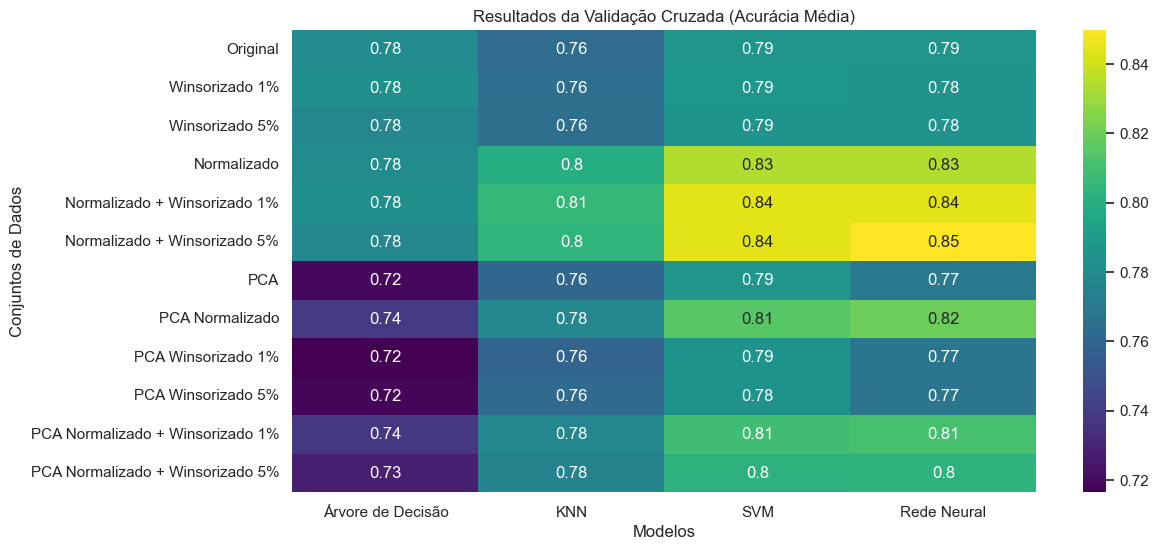

In [9]:
"""
Modelos utilizados
"""
models = {
    "Árvore de Decisão": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Rede Neural": MLPClassifier(random_state=RANDOM_STATE),
}

"""
Validação cruzada
"""
cv_results = {}
for name, dataset in bases_treino_undersampled.items():
    print(f"\nRealizando validação cruzada para a base: {name}")
    X = dataset.drop(columns=['class'])
    y = dataset['class']
    cv_scores = perform_cross_validation(X, y, models, cv_folds=5)
    cv_results[name] = cv_scores

cv_results_df = pd.DataFrame(cv_results).transpose()
print("\nResultados da Validação Cruzada:")
print(cv_results_df)
plt.figure(figsize=(12, 6))
sns.heatmap(cv_results_df, annot=True, cmap='viridis')
plt.title('Resultados da Validação Cruzada (Acurácia Média)')
plt.xlabel('Modelos')
plt.ylabel('Conjuntos de Dados')
plt.show()


# Salvando bases finais

In [10]:
bases_treino['Normalizado + Winsorizado 1%'] .to_csv('train_winsor_1_norm.csv', index=False)
validation_winsor_1.to_csv('validation_winsor_1.csv', index=False)
test_data.to_csv('test.csv', index=False)